<a href="https://colab.research.google.com/github/SzTk/DLFS_Chap5/blob/master/DLFS2_Chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 344, done.
remote: Total 344 (delta 0), reused 0 (delta 0), pack-reused 344
Receiving objects: 100% (344/344), 7.65 MiB | 31.96 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [3]:
%cd deep-learning-from-scratch-2
!git show HEAD

/content/deep-learning-from-scratch-2
commit 65a3d98c5fba1ce4d2d8f58ac3e5dbde0cb5094d (HEAD -> master, origin/master, origin/HEAD)
Merge: 2faf553 c28cb04
Author: Koki Saitoh <koki0702@gmail.com>
Date:   Mon Jan 21 18:49:04 2019 +0900

    Merge pull request #8 from po3rin/edit_docstring
    
    remove extra space & correcting wrong docstring



In [0]:
from IPython.display import Image, display_png

# ５章　リカレントニューラルネット（RNN)

この章では、リカレントニューラルネットを導入する。
リカレントニューラルネットは、ループした経路を持つニューラルネットである。

4章までは単語のベクトル表現を考察し、単語感の類似度を数値的に表現するモデルを作ることができた。

5章では、文章についてのモデル、「言語モデル」を作る。

## 5.1 言語モデル
言語モデルとは単語の並びに対してそれがどれだけ起こりそうか、確率を与えるモデル。  
4章までは単語一つづつだったが、言語モデルは単語列、つまり文章についての確率。  
例えば、  
"You say goodbye"には高い確率（例えば0.092)を与え、  
"you say good die"には低い確率（例えば0.0000000000032)を出力するようなモデル。

数式で表現すると、下記になる。

---
> m語からなる文章を考える。各単語を$w_1, \cdots ,w_m$とする。  
> 言語モデルは下記の同時確率を与えるモデルである
$$
P(w_1,\cdots ,w_m)
$$

---

このようなモデルは、例えば音声認識に応用できる。  
音声を聞き取った結果にいくつかの候補があった場合、最も確率も高いものを採用する、といった用途に使える。  
また、文章の生成（サンプリング）もできる。


### 言語モデルの変形
言語モデルは

$$
P(w_1,\cdots ,w_m)
$$

と書けるが、条件付き確率の法則（乗法定理）を用いて分解でき、

$$
P(w_1, \cdots ,w_m) = P(w_m|w_1,\cdots , w_{m-1})P(w_{m-1}|w_1,\cdots ,w_{m-2})\cdots P(w_2|w_1)p(w_1)
$$

と書ける。
つまり、  
> 最初の一語の確率＊（最初の一語の次に第二語が来る確率）＊（最初の二単語の次に、第三語が来る確率）＊ ・・・  

と書くことができる。

(乗法定理$P(A,B)=P(A|B)P(B)$を使っているとこの本には書いてあるが、あんまりこれを定理とは言わないような気がする。
条件付き確率の定義では？)  
ともかく、
$$
P(w_1, \cdots ,w_m) = \prod_{t=1}^m P(w_t|w_1,\cdots ,w_{t-1})
$$

がえられた。

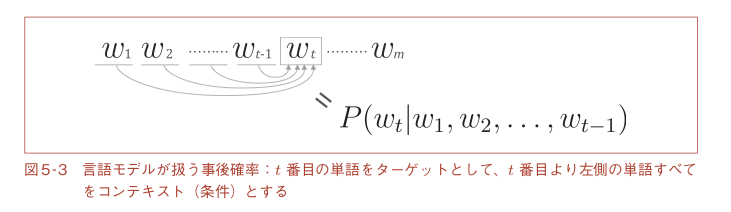

In [5]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig2.png'))


この変形により、言語モデルを得るためには、上記式の右辺

$$
P(w_t|w_1,\cdots ,w_{t-1})
$$

 が計算できれば良いことがわかった。

  ### RNNの必要性
  
  言語モデルを作るとき、4章まで作ってきたCBOWモデルだと無理がある。
  CBOWモデルは、周囲の単語から、対象とする位置の単語を予測するモデルであった。
  周囲の単語の範囲は、両隣りだった。数を増やすことも可能だが、下記のように
  遠く離れた単語を覚えておくことは難しいし、効率的ではない。
  
  ```
  長いコンテキストが必要な例
  "Tom was watching TV in his room, Mary came into the room. Mary said hi to □□□"
  ```
  
 それだけではなく、CBOWモデルでは単語の順番は無視されてしまう。  
 （両隣りの単語の和が評価されるので、　\[you, □□□, say\] と\[say, □□□,  you\]　は同じ問題になってしまう）
 
 そこで、原理的には無限の過去までさかのぼって状態を保持できる、RNNを導入する。
 
 なお、RNNを使わないでやる試みもあるようで、"Neural Probablistic language model [28]" では、RNNでない試みを行っているらしい。

## 5.2 RNN
RNNは、ループした経路を持つニューラルネットである。


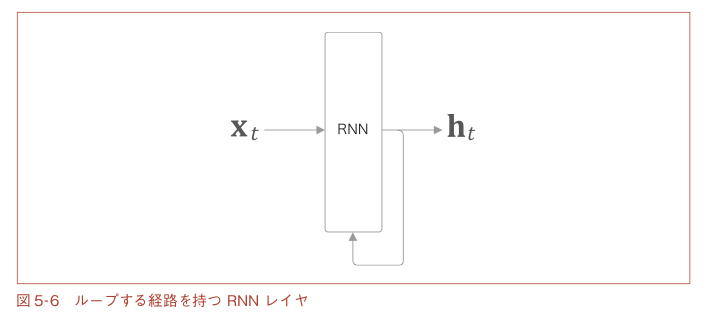

In [4]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig1.png'))

$\mathbf{X}_t $ と$\mathbf{h}_{t-1}$を入力され、$\mathbf{h}_t$を出力する。


> Xは観測値で、hは（隠れ）状態。   
> 自然言語は文脈があるし、次の単語は文脈に依存するとともに、  
> 文脈自体は直前の単語によって変化するため。  

> 文脈という概念を、数学的に表現する方法として隠れ状態を導入して、  
> 隠れ状態を扱えるニューラルネットとしてRNNを導入したイメージ。  



上記図の表記を90度回転させ、ループを展開すると、下記のように書ける。

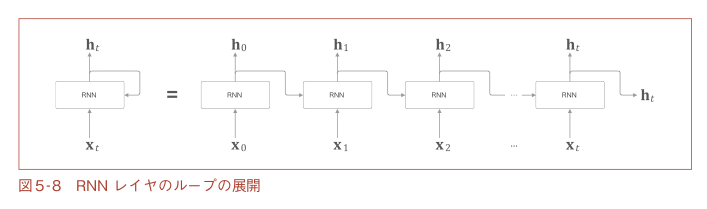

In [18]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig3.png'))

各時刻のRNNレイヤは、そのレイヤへの入力と、一つ前のRNNレイヤの出力を受け取り、  
その2つの情報をもとに、その時刻の出力を計算する。

具体的には$\tanh$を用いて下記のように計算する（ものらしい？）

$$
\bf{h}_t = \tanh (\bf{h}_{t-1} \bf{W}_h + \bf{x}_t \bf{W}_x + b)
$$

> $\tanh$を用いると、状態が無限大に発散することはなくなるだろう。  
> 代わりに、状態自体のダイナミクスを解析するのが難しくなるのでは？という気がする。

### Backpropergation Through Time (BPTT)

RNNでは、順伝搬は過去から未来方向、  
逆伝搬は未来から過去へさかのぼってゆく方向 で、通常のNNと同様、forward/backwardを実行できる。

これを、Backpropergation Through Time (BPTT)という。

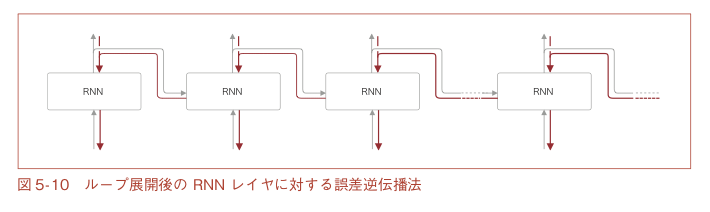

In [19]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig5.png'))

### Truncated BPTT

逆伝搬が長くなると、学習の安定性やメモリ消費量の問題が起こる。  
コーパスの長さだけ、ネットワーク自体の大きさも増えるため。
1000語からなるコーパスを、図5-10のやり方で単純に学習させようとすると、RNNレイヤが1000個積み重なる必要がある。

そこで、順伝搬はコーパス全体で行い、逆伝搬を一定の長さで切ることを行う。
例えば10個で切ることを考えると、コーパスを10語ごとに区切って学習することに似ている。
ただし、順伝搬はコーパス全体なので、完全に区切って学習しているわけではない。

順伝搬では、状態出力$\bf{h}_t$だけを伝えれば良いので、メモリへの負担が無い。
そのため順伝搬はコーパス全体で行うことができる。

> 逆伝搬でも、うまくやればメモリを増やさずに逆伝搬できそうな気もするが、なぜ出来ないのかは鈴木はよくわからない。

これをTruncated BPTTという。


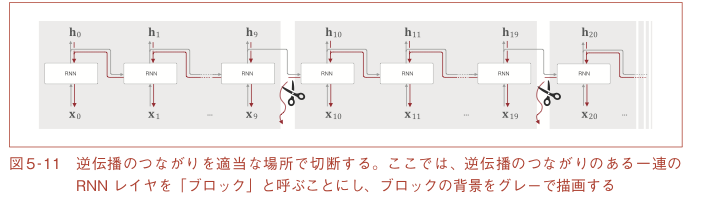

In [20]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig6.png'))

下記の図5-14では、順伝搬において、状態出力$\bf{h}_t$だけ伝えれば良いことを表現している

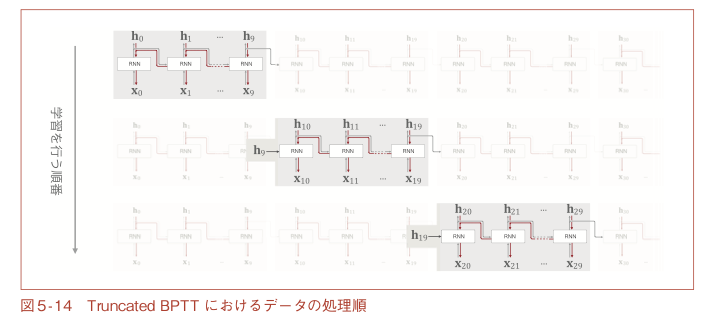

In [22]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig9.png'))

### Truncated BBTTのミニバッチ学習

上記までの説明はミニバッチ学習は考えていなかった。  
RNNでミニバッチをするときは、データを順番を保って（シーケンシャルに）渡す必要がある。
バッチを作る際はデータの開始位置をズラす方式で作成する。

具体的には、例えば  $[x_0 \sim x_{9}]$までをバッチ１，$[x_{500} \sim x_{509}]$までをバッチ２、というふうに作成する。

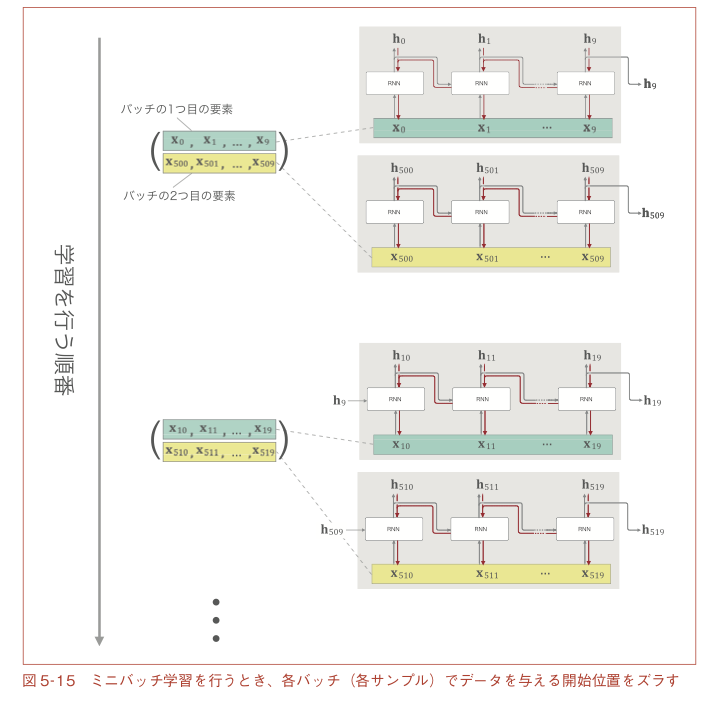

In [24]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig10.png'))

コードで書くと、下記のようにバッチを作成している。

```
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）入力を一個ずらしただけである。
data_size = len(xs)

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch): 
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
```

### 5.3 RNNの実装

これまで見てきたように、RNNはつまるところ、横方向に伸びたニューラルネットであり、  
その横幅も、TruncatedBPTTのために、一定の幅で良いことがわかった。
具体的には下記図5-16のようなニューラルネットである。  
T個のxを入力され、T個のhを出力する。

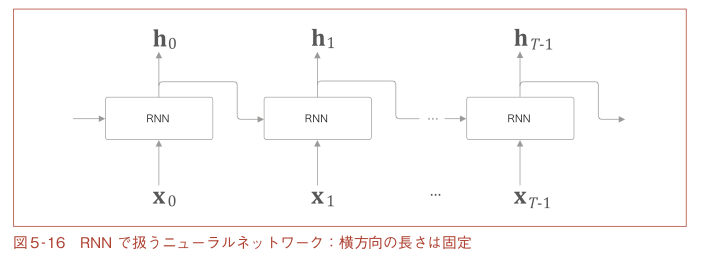

In [29]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig11.png'))

これをまとめて一つのレイヤとみなして、下記図5-17のように書く。  
Tステップ分のRNNをまとめたレイヤを、「TimeRNN」レイヤとこの本では呼んでいる。

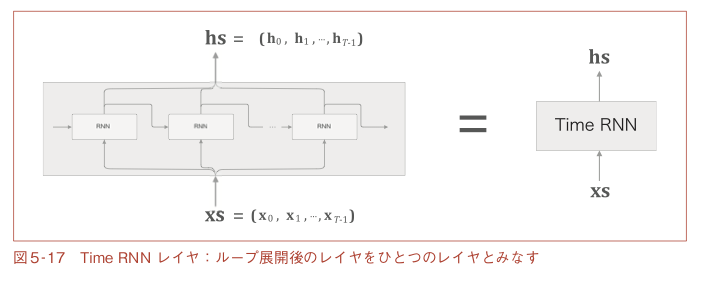

In [26]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig12.png'))

### RNNレイヤ 順伝搬の実装

順伝搬は、

$$
\bf{h}_t = \tanh (\bf{h}_{t-1} \bf{W}_h + \bf{x}_t \bf{W}_x + b)
$$

に従って実装する。

```
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next
```

self.casheに、前ステップの状態h_prevと今回ステップの状態h_nextを入れている。  
これは逆伝搬のときに利用する。

下記図5-18のように、行列計算の次元に注意

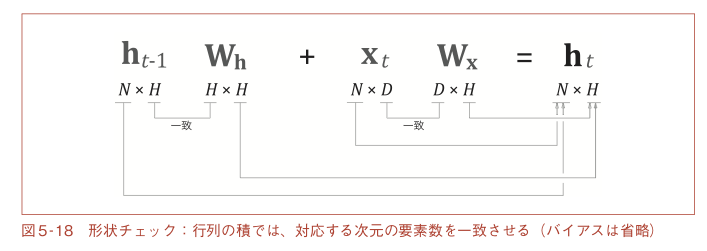

In [30]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig13.png'))

### RNNレイヤ 逆伝搬の実装

１章でやった逆伝搬の計算方法に従って、逆伝搬を実装する。

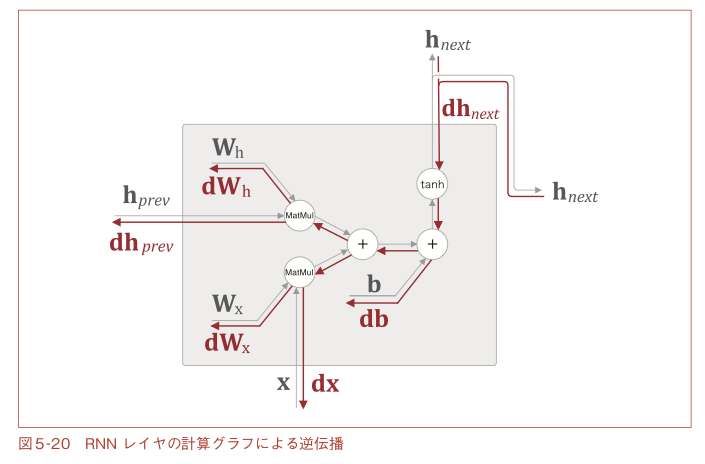

In [31]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig15.png'))


```
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev
```

### TImeRNNレイヤ の実装

TimeRNNとRNNの関係は下記図5-21の様であった。

TimeRNNのforwardでは、時刻順にRNNのforwardを実行。  
TimeRNNのbackwardでは、時刻の逆順にRNNのbackwardを実行すればよい。

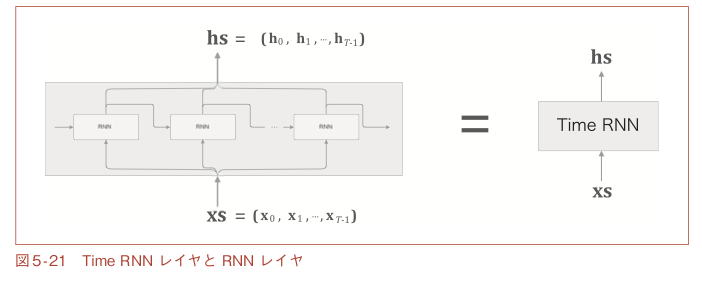

In [35]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig16.png'))


```
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]  　# 枠だけ用意
        self.layers = None   # 初期化時にはレイヤは作らない。

        self.h, self.dh = None, None
        self.stateful = stateful  # 後の拡張性のために作成

    def set_state(self, h):  # 後の拡張性のために作成
        self.h = h

    def reset_state(self):  # 後の拡張性のために作成
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params  
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:   # statefulじゃないければ、ゼロで状態を初期化
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)  # ここで書くRNNレイヤを作る。重みなどのパラメータはすべて同じ。
            self.h = layer.forward(xs[:, t, :], self.h)  # 各RNNレイヤのfowradを実行
            hs[:, t, :] = self.h  # ベクトルにしてまとめて、保存。
            self.layers.append(layer)  # レイヤを保存

        return hs

```

状態$\bf{h}$をTimeRNNクラスのメンバとして保持することで、ブロック間での隠れ状態の引き継ぎが可能になる。

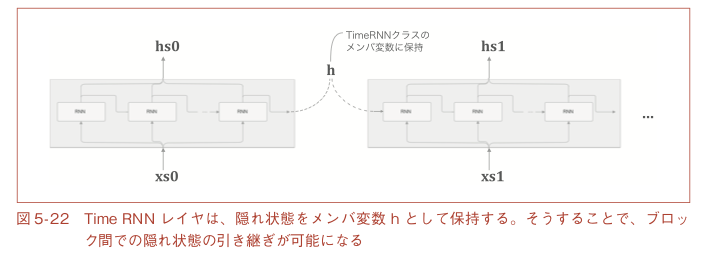

In [36]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig17.png'))

### TimeRNN 逆伝搬の実装

逆伝搬は、dhsを引数として受け取って、dxsを戻り値とする関数になる。

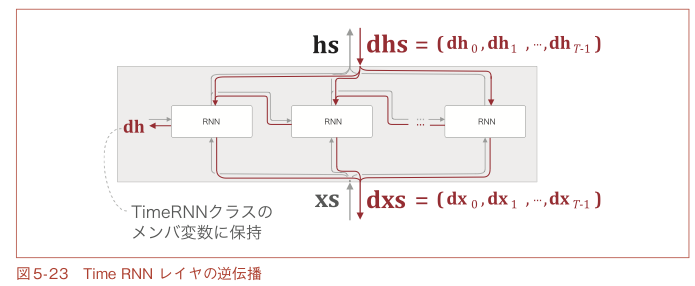

In [38]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig18.png'))

未来から過去に向かってRNNのbackwardを実行すればよい。

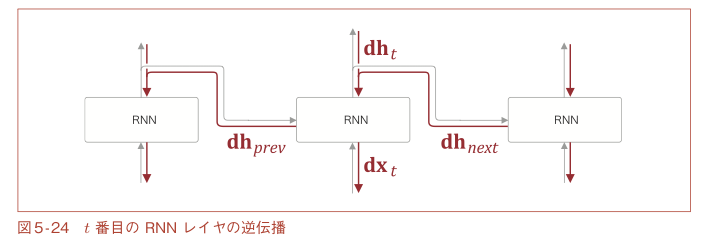

In [39]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig19.png'))


```
def backward(self, dhs):  # dhsが引数にある
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):  # 逆向きにループ
            layer = self.layers[t]  # 各RNNレイヤを取りだす
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 書くRNNレイヤのbackward。
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):  # 勾配は、各RNNレイヤから得られた勾配の合計（和）である。
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs
```

## 5.4 時系列データを扱うレイヤの実装　
### RNN以外のレイヤ（Softmax,Affine,Enmedding等）のTImeレイヤ化

下記図5-25に示すように、RNNがあると、実際には展開して横に広がったレイヤを作る必要がある。

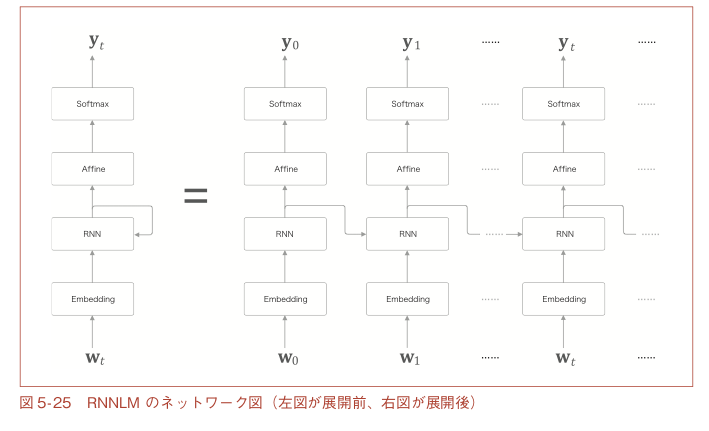

In [40]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig20.png'))

In [0]:
# display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig21.png'))

RNNを集めてTImeRNNレイヤを作ったように、他のレイヤも集めてTime化する。

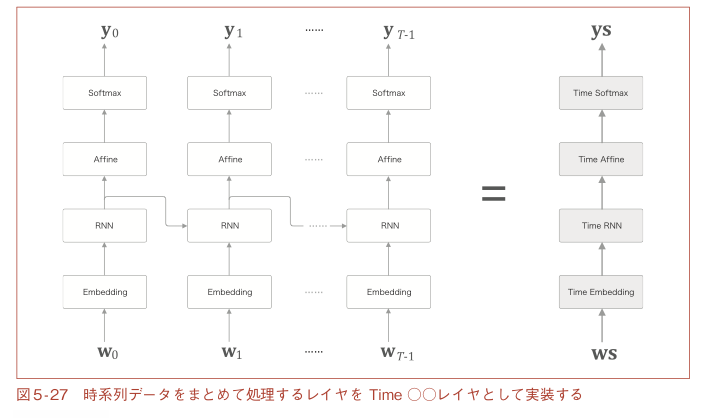

In [42]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig22.png'))

TimeAffineや、TimeEnbeddingの詳細は割愛。  
基本的にはT個のレイヤを作成して、それぞれ個別にforward/backwardを実行すればよい。   
RNNとは異なり、各レイヤ間の関係は無いため。

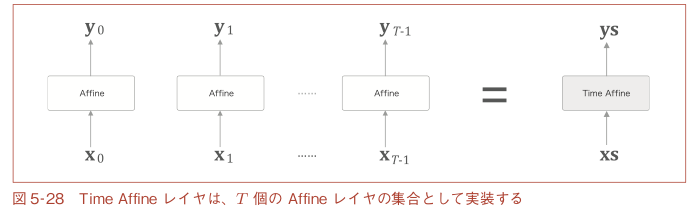

In [43]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig23.png'))

Softmaxレイヤに関してもほぼ同じだが、一点だけ異なるのは  
最後にロスの平均をとって、全体のロスとする点。

これをTime Softmax with Lossレイヤと呼んでいる。

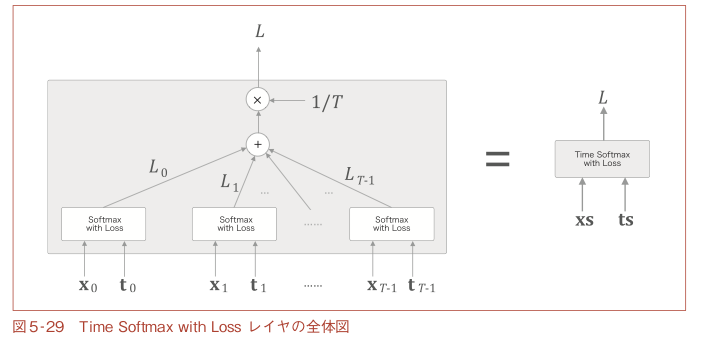

In [44]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig24.png'))

出来上がったネットワークの全体像。

これをSimpleRnnlmと呼んでいる。

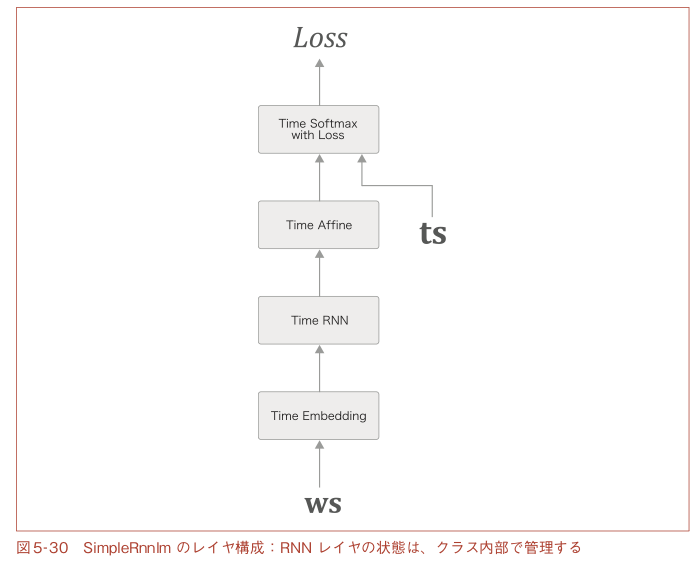

In [45]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig25.png'))

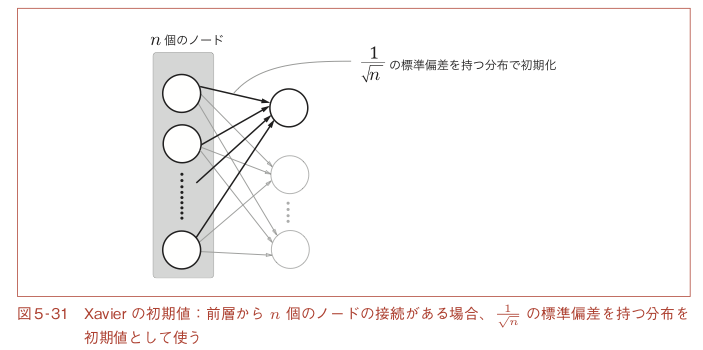

In [46]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig26.png'))

「sklearnとtensorflowで実践機械学習」の11章(11.1)にこころが書いてある。

## 5.5 評価方法

出来上がった言語モデルの評価方法について。

言語モデルの評価は、"パープレキシティ(perprexily)"がよく用いられる。

perprexilyは、確率の逆数のこと。

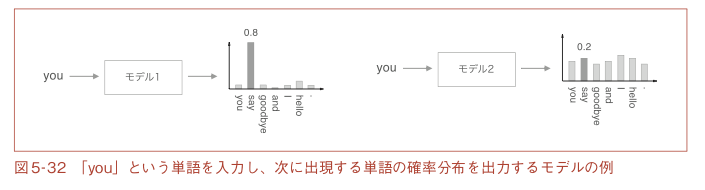

In [47]:
display_png(Image('https://github.com/SzTk/DLFS_Chap5/raw/master/figures/DLFS_Chap5_fig27.png'))

上記例で、左のモデルのperplexityは1/0.8=1.25  
右のモデルのperplexityは、1/0.2=5  
となる。  
perplexityは値が小さい方が良い。

コーパス全体に対するperplexityの計算は、下記で行う。

$$
L = - \frac{1}{N}\sum_n \sum_k t_{nk} \log y_{nk}  
$$
$$
\text{perplexity} = e^L
$$

$t_{nk}$はOne-Hot表現の正解ラベル。
$y_{nk}$は、言語モデルで出力された確率。

つまり、コーパス全体に対する、確率の相乗平均の逆数、が、コーパス全体に対するperprexilyになる？

## 実行

### RNNの実装

In [0]:
# This is identical to common.time_layer.RNN
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

... は Ellipsis という組み込み定数。

### TImeRNNの実装

In [0]:
# This is identical to common.time_layer.TimeRNN

from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


### RNN LM の実装

In [0]:
# This code is identical to chap5.simply_rnnlm.SimpleRnnlm

import sys
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 訓練の実行

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 389.82
| epoch 2 | perplexity 262.33
| epoch 3 | perplexity 226.45
| epoch 4 | perplexity 216.47
| epoch 5 | perplexity 206.95
| epoch 6 | perplexity 203.51
| epoch 7 | perplexity 199.62
| epoch 8 | perplexity 196.81
| epoch 9 | perplexity 191.62
| epoch 10 | perplexity 193.12
| epoch 11 | perplexity 188.40
| epoch 12 | perplexity 192.18
| epoch 13 | perplexity 188.97
| epoch 14 | perplexity 190.48
| epoch 15 | perplexity 188.95
| epoch 16 | perplexity 186.07
| epoch 17 | perplexity 183.17
| epoch 18 | perplexity 179.50
| epoch 19 | perplexity 180.93
| epoch 20 | perplexity 181.80
| epoch 21 | perplexity 179.70
| epoch 22 | perplexity 175.63
| epoch 23 | perplexity 172.89
| epoch 24 | perplexity 173.07
| epoch 25 | perplexity 170.74
| epoch 26 | perplexity 169.87
| epoch 27 | perplexity 165.55
| epoch 28 | perplexity 162.95
| epoch 29 | perplexity 160.56
| epoch 30 | perplexity 154.92
| epoch 31 | perplexity 154.60
| e

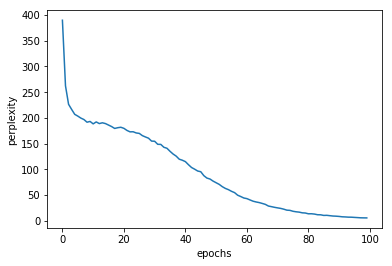

In [8]:
# This code is identical to chap5.train_custum_loop.py

import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.52
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 353.56
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 244.93
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 217.11
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 208.23
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 206.69
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.15
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.63
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.88
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.30
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.23
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 188.89
| epoch 13 |  iter 1 / 19 | time 1[s] | perplexity 192.88
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 187.74
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 186.72
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 191.18
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 189.42
| epoch 18 |  iter 1 / 

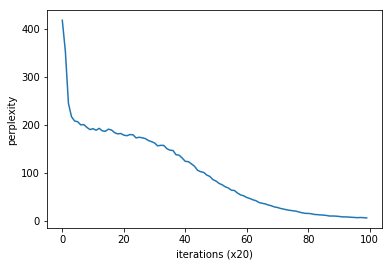

In [9]:
# This code is identical to chap5.train.py

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()